In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pybrain.datasets import SupervisedDataSet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import TanhLayer, LinearLayer
import statsmodels.api as sm
from pybrain.structure import FullConnection
import pickle

In [2]:
data = pd.read_csv('UE_06_dataset04_joint_scraped_data.csv')
data.head()

,x,y
0,0.211976,6.694553e-159
1,0.087438,6.960205e-159
2,0.818725,5.560001e-158
3,0.950282,5.445055e-158
4,0.047747,8.367187e-159


In [3]:
data.columns = ["x", "y"]
data = data.apply(pd.to_numeric, errors='coerce')
data.dropna(inplace=True)  # Drop rows with missing values
data.drop_duplicates(inplace=True)  # Remove duplicate rows


In [4]:
 # Handle outliers using Z-score
for column in data.select_dtypes(include=np.number).columns:
    z_scores = (data[column] - data[column].mean()) / data[column].std()
    data = data[(z_scores.abs() < 2)]


In [5]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]


In [6]:
for column in data.select_dtypes(include=np.number).columns:
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

In [12]:
X =  data.iloc[:, :-1].values  # Features
y =  data.iloc[:, -1].values  # Target


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

ValueError: Expected 2D array, got 1D array instead:
array=[0.09906375 0.10299478 0.8227503  ... 0.22099479 0.84276772 0.25086112].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
y_pred_ols = ols_model.predict(X_test)
print(f"OLS Model - MSE: {mean_squared_error(y_test, y_pred_ols)}, R2: {r2_score(y_test, y_pred_ols)}")


OLS Model - MSE: 0.00518272169636703, R2: 0.9029746684121528


In [15]:
input_size = X_train.shape[1]
ann = buildNetwork(input_size, 5, 1)  # Simple feedforward network

train_ds = SupervisedDataSet(input_size, 1)

for i in range(len(X_train)):
    train_ds.addSample(X_train[i], y_train[i])

model = BackpropTrainer(ann, train_ds, learningrate=0.01, momentum=0.9)
model.trainUntilConvergence(maxEpochs=100)


([0.00701712696689325,
  0.0026305943851311314,
  0.002616518745816519,
  0.0026056568093350743,
  0.0026114421865262027,
  0.0026037757619317035,
  0.0026289095684625167,
  0.0026083950915399114,
  0.002607175093448344,
  0.0025739960874996324,
  0.002614365574364919,
  0.0026080430938238888,
  0.0026003985047097344,
  0.0025644994923866983,
  0.002545753788449322,
  0.0025920551733447116,
  0.002586012842007982,
  0.0025659964046551753,
  0.0025664591148489464,
  0.0026146728132459777,
  0.0026134040840169086,
  0.0025702659510541998,
  0.002576468185915625,
  0.0025720248114972284,
  0.002559513534504761,
  0.002571120462196894,
  0.002531290925070137,
  0.002606112392452075,
  0.0025560598231625827,
  0.0025514813142067474,
  0.002513084601343143,
  0.0025639308106655116,
  0.0025832962024123418,
  0.002552010379462809,
  0.0025374012260450736,
  0.0025464008253850133,
  0.002522312635355932,
  0.002518461914289389,
  0.0025255523600460077,
  0.0025434799003132037,
  0.002552021785

In [28]:
ann_model = 'UE_05_App3_ANN_Model.pkl'
with open(ann_model, 'wb') as f:
    pickle.dump(ann, f)

In [29]:
with open(ann_model, 'rb') as f:
    loaded_network = pickle.load(f)

In [30]:
y_pred_ols = ols_model.predict(X_test)
y_pred_ann = np.array([ann.activate(x) for x in X_test]).flatten()


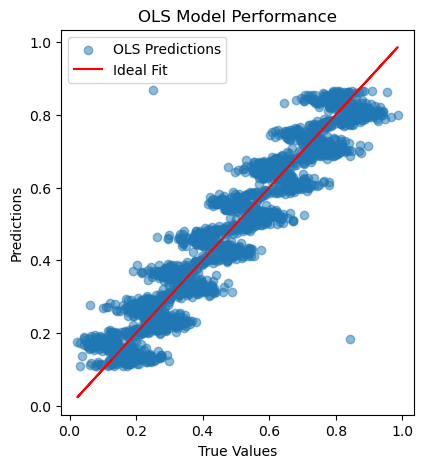

In [31]:
plt.figure(figsize=(10, 5))

# Plot OLS predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ols, alpha=0.5, label="OLS Predictions")
plt.plot(y_test, y_test, color="red", label="Ideal Fit")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('OLS.pdf')
plt.title("OLS Model Performance")
plt.legend()
plt.show()
plt.close()


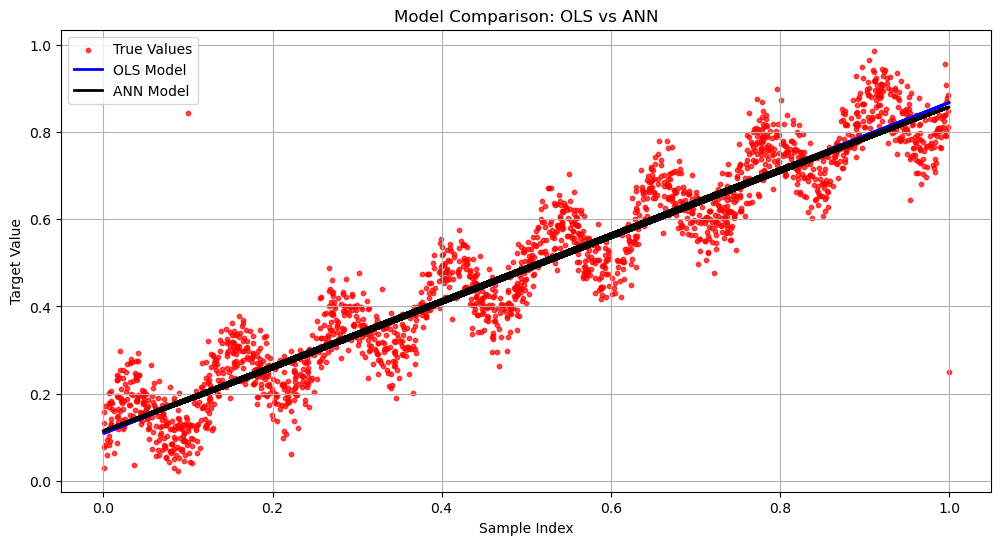

In [32]:
# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, color='red', label='True Values', alpha=0.7, s=10)  # True data points
plt.plot(X_test, y_pred_ols, color='blue', label='OLS Model', linewidth=2)  # OLS predictions
plt.plot(X_test, y_pred_ann, color='black', label='ANN Model', linewidth=2)  # ANN predictions

plt.title("Model Comparison: OLS vs ANN")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.show()